In [0]:
# # Install the PyDrive wrapper & import libraries.
# # This only needs to be done once per notebook.
# !pip install -U -q PyDrive
# from pydrive.auth import GoogleAuth
# from pydrive.drive import GoogleDrive
# from google.colab import auth
# from oauth2client.client import GoogleCredentials

# # Authenticate and create the PyDrive client.
# # This only needs to be done once per notebook.
# auth.authenticate_user()
# gauth = GoogleAuth()
# gauth.credentials = GoogleCredentials.get_application_default()
# drive = GoogleDrive(gauth)

# # Download a file based on its file ID.
# #
# # A file ID looks like: laggVyWshwcyP6kEI-y_W3P8D26sz
# #file_id = 'REPLACE_WITH_YOUR_FILE_ID'
# #downloaded = drive.CreateFile({'id': file_id})
# #print('Downloaded content "{}"'.format(downloaded.GetContentString()))

In [8]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
import os
import pandas as pd
!ls "/content/drive/My Drive/GoogleDrive20180110/DoutoradoUSP/DATA_HAM"
base_skin_dir = '/content/drive/My Drive/GoogleDrive20180110/DoutoradoUSP/DATA_HAM'
base_skin_data_dir = os.path.join('/content/drive/My Drive/GoogleDrive20180110/DoutoradoUSP/DATA_HAM', 'HAM10000')
print(base_skin_dir)
print(base_skin_data_dir)
tile_df = pd.read_csv(os.path.join(base_skin_dir, 'HAM10000_metadata.csv'))
print(tile_df.shape)

category_samples.png  HAM10000		     SKIN_HAM_Model_v2.h5
Figure_1.png	      HAM10000_metadata.csv  Teste_Webcam_Jau.py
final_weights.hdf5    SKIN_HAM_Model.h5
/content/drive/My Drive/GoogleDrive20180110/DoutoradoUSP/DATA_HAM
/content/drive/My Drive/GoogleDrive20180110/DoutoradoUSP/DATA_HAM/HAM10000
(10015, 7)


In [0]:
#"Inicialização"
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
import seaborn as sns
from PIL import Image

from sklearn.metrics import confusion_matrix
import itertools

import keras
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
# Todo: At some point it might be useful to use another framework like Pytorch and see how that compares to Tensorflow.

import timeit
from time import time
from tensorflow.python.keras.callbacks import TensorBoard
import cv2

#################################################################
#################################################################
#################################################################
#################################################################
#################################################################
# TensorBoard


In [0]:
tensorboard=TensorBoard(log_dir="logs/{}".format(time()))
#Re-train with callback





In [0]:
# Merge images from both folders into one dictionary

imageid_path_dict= []
imageid_path_dict=os.listdir(base_skin_data_dir)

for ii in range(len(imageid_path_dict)):
  imageid_path_dict[ii]=os.path.join(base_skin_data_dir, imageid_path_dict[ii])
len(imageid_path_dict)
tile_df['path'] = imageid_path_dict



In [13]:
tile_df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/content/drive/My Drive/GoogleDrive20180110/Do...
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/content/drive/My Drive/GoogleDrive20180110/Do...
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/content/drive/My Drive/GoogleDrive20180110/Do...
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/content/drive/My Drive/GoogleDrive20180110/Do...
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/content/drive/My Drive/GoogleDrive20180110/Do...


In [14]:

# This dictionary is useful for displaying more human-friendly labels later on

lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}


# Read in the csv of metadata

# Create some new columns (path to image, human-readable name) and review them

tile_df['cell_type'] = tile_df['dx'].map(lesion_type_dict.get) 
tile_df['cell_type_idx'] = pd.Categorical(tile_df['cell_type']).codes
tile_df.sample(5)



,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
9001,HAM_0004337,ISIC_0031981,nv,histo,40.0,male,chest,/content/drive/My Drive/GoogleDrive20180110/Do...,Melanocytic nevi,4
3690,HAM_0006982,ISIC_0032071,nv,follow_up,30.0,male,lower extremity,/content/drive/My Drive/GoogleDrive20180110/Do...,Melanocytic nevi,4
9709,HAM_0006898,ISIC_0030242,akiec,histo,80.0,male,scalp,/content/drive/My Drive/GoogleDrive20180110/Do...,Actinic keratoses,0
5756,HAM_0001013,ISIC_0031533,nv,follow_up,75.0,male,lower extremity,/content/drive/My Drive/GoogleDrive20180110/Do...,Melanocytic nevi,4
8402,HAM_0007480,ISIC_0024406,nv,histo,35.0,male,foot,/content/drive/My Drive/GoogleDrive20180110/Do...,Melanocytic nevi,4


In [15]:
tile_df.groupby('dx').count()


,lesion_id,image_id,dx_type,age,sex,localization,path,cell_type,cell_type_idx
dx,,,,,,,,,
akiec,327,327,327,327,327,327,327,327,327
bcc,514,514,514,514,514,514,514,514,514
bkl,1099,1099,1099,1089,1099,1099,1099,1099,1099
df,115,115,115,115,115,115,115,115,115
mel,1113,1113,1113,1111,1113,1113,1113,1113,1113
nv,6705,6705,6705,6660,6705,6705,6705,6705,6705
vasc,142,142,142,142,142,142,142,142,142


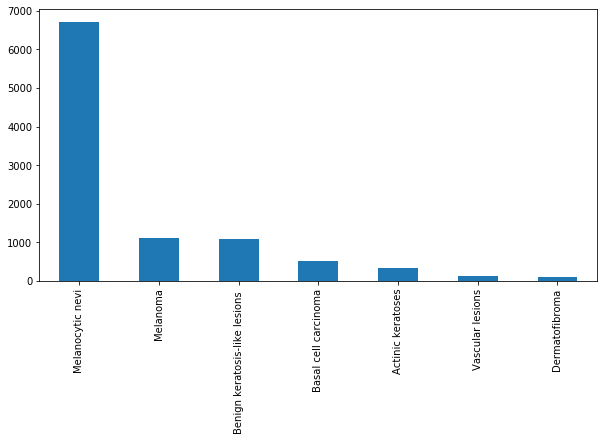

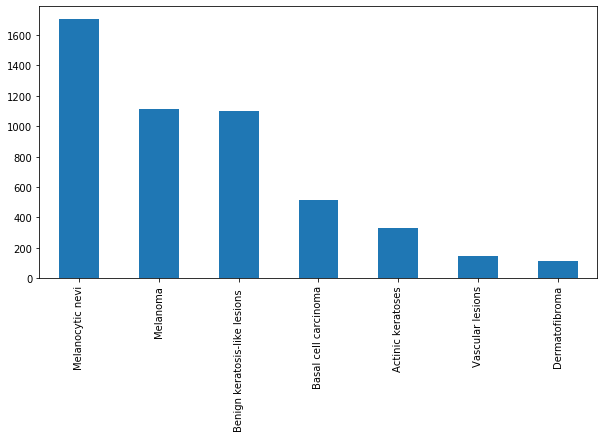

In [16]:


#"Exploratory data analysis"

# Get general statistics for the dataset



# Let's see the distribution of different cell types

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)




# Too many melanocytic nevi - let's balance it a bit!

tile_df = tile_df.drop(tile_df[tile_df.cell_type_idx == 4].iloc[:5000].index)

fig, ax1 = plt.subplots(1, 1, figsize= (10, 5))
tile_df['cell_type'].value_counts().plot(kind='bar', ax=ax1)


In [0]:
#tile_df['path']


In [17]:
#"Import and resize images"

input_dims = (140, 140)
input_shape = input_dims + (3,)


# Load in all of the images into memory - this will take a while.  
# We also do a resize step because the original dimensions of 450 * 600 * 3 was too much for TensorFlow
tic=timeit.default_timer()
tile_df['image'] = tile_df['path'].map(lambda x: np.asarray(Image.open(x).resize(input_dims)))
toc=timeit.default_timer()
toc-tic



2147.600979161

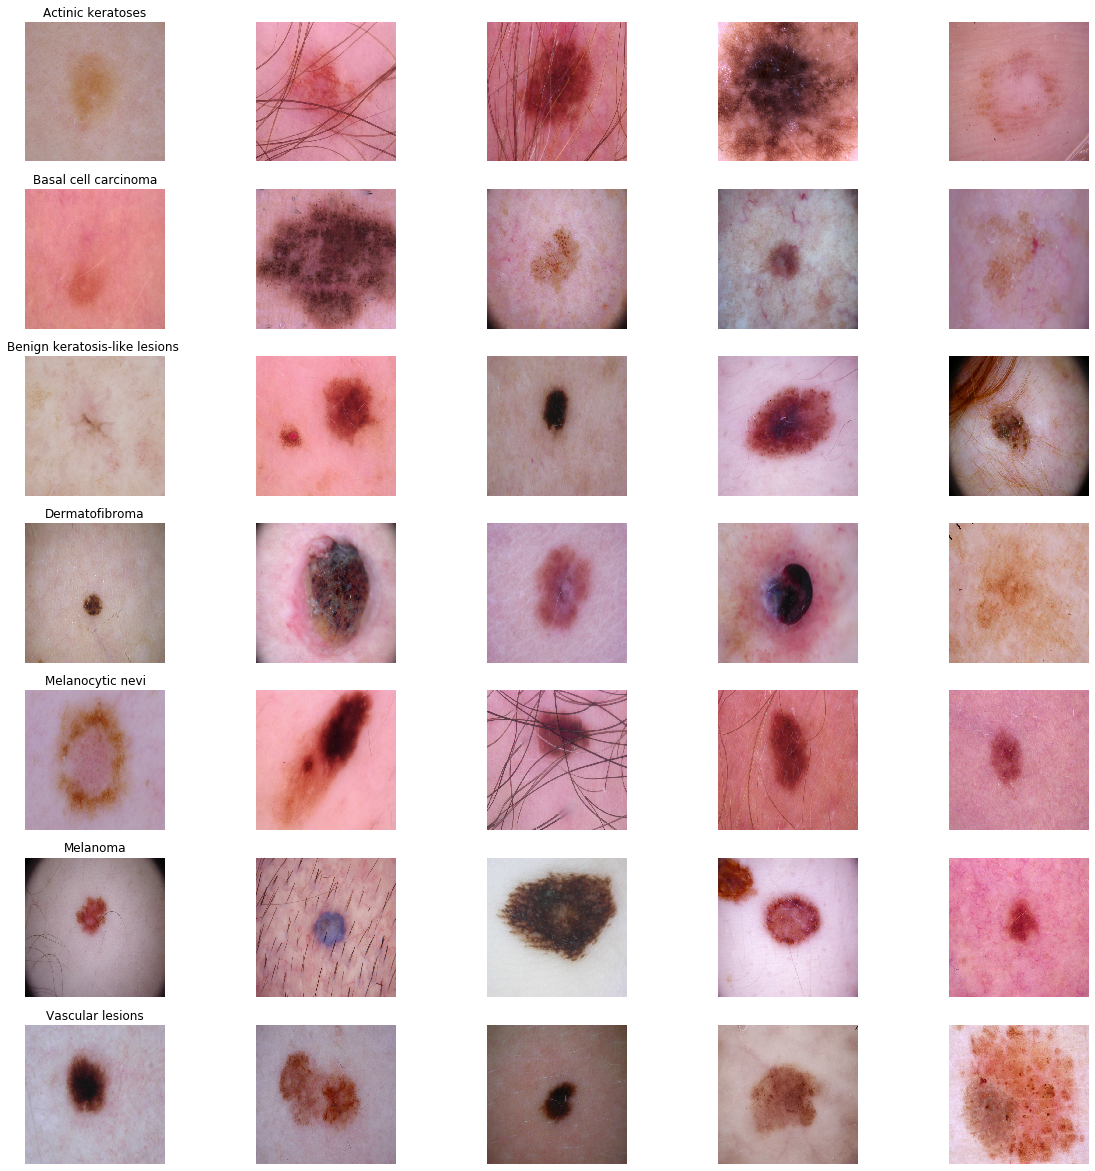

In [18]:
#"Seeing is believing"
n_samples = 5
fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         tile_df.sort_values(['cell_type']).groupby('cell_type')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=2018).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')
#fig.savefig('category_samples.png', dpi=300)

In [19]:
# See the image size distribution - should just return one row (all images are uniform)
tile_df['image'].map(lambda x: x.shape).value_counts()


(140, 140, 3)    5015
Name: image, dtype: int64

In [0]:
#"Deep Convolutional Classifier"
#"Create train and test set"

# Shuffle the initial dataset
tile_df = tile_df.sample(frac=1)

# Training and test set division
train = tile_df[:-500]
test = tile_df[-500:]


#"Assign data structures"

x_train = np.asarray(train['image'].tolist()).reshape((train.shape[0],)+input_shape) #/ 255
x_test = np.asarray(test['image'].tolist()).reshape((test.shape[0],)+input_shape) #/ 255

'''
x_train_mean = np.mean(x_train, axis=0)
x_train_mean_reptrain = np.repeat(x_train_mean[np.newaxis,:,:,:], x_train.shape[0], axis=0)
x_train_mean_reptest = np.repeat(x_train_mean[np.newaxis,:,:,:], x_test.shape[0], axis=0)

x_train = (x_train - x_train_mean_reptrain)
x_test = (x_test - x_train_mean_reptest)
'''

#"Create image augmentor"

y_train = train['cell_type_idx']
y_test = test['cell_type_idx']

# Perform one-hot encoding on the labels
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)





In [21]:
x_train.shape

(4515, 140, 140, 3)

In [0]:
datagen = ImageDataGenerator(
    featurewise_center=True,
    featurewise_std_normalization=True, 
    rotation_range=20,
    width_shift_range=0.05,
    height_shift_range=0.05,
    zoom_range=0.05,
    horizontal_flip=True,
    vertical_flip=True)
datagen.fit(x_train)

In [0]:
# import the necessary packages
from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import concatenate

In [0]:
def minigooglenet_functional(width, height, depth, classes):
  
  def conv_module(x, K, kX, kY, stride, chanDim, padding="same"):
    # define a CONV => BN => RELU pattern
    x = Conv2D(K, (kX, kY), strides=stride, padding=padding)(x)
    x = BatchNormalization(axis=chanDim)(x)
    x = Activation("relu")(x)

    # return the block
    return x

  def inception_module(x, numK1x1, numK3x3, chanDim):
    # define two CONV modules, then concatenate across the
    # channel dimension
    conv_1x1 = conv_module(x, numK1x1, 1, 1, (1, 1), chanDim)
    conv_3x3 = conv_module(x, numK3x3, 3, 3, (1, 1), chanDim)
    x = concatenate([conv_1x1, conv_3x3], axis=chanDim)

    # return the block
    return x

  def downsample_module(x, K, chanDim):
    # define the CONV module and POOL, then concatenate
    # across the channel dimensions
    conv_3x3 = conv_module(x, K, 3, 3, (2, 2), chanDim,
    padding="valid")
    pool = MaxPooling2D((3, 3), strides=(2, 2))(x)
    x = concatenate([conv_3x3, pool], axis=chanDim)

    # return the block
    return x

  # initialize the input shape to be "channels last" and the
  # channels dimension itself
  inputShape = (height, width, depth)
  chanDim = -1

  # define the model input and first CONV module
  inputs = Input(shape=inputShape)
  x = conv_module(inputs, 96, 3, 3, (1, 1), chanDim)

  # two Inception modules followed by a downsample module
  x = inception_module(x, 32, 32, chanDim)
  x = inception_module(x, 32, 48, chanDim)
  x = downsample_module(x, 80, chanDim)

  # four Inception modules followed by a downsample module
  x = inception_module(x, 112, 48, chanDim)
  x = inception_module(x, 96, 64, chanDim)
  x = inception_module(x, 80, 80, chanDim)
  x = inception_module(x, 48, 96, chanDim)
  x = downsample_module(x, 96, chanDim)

  # two Inception modules followed by global POOL and dropout
  x = inception_module(x, 176, 160, chanDim)
  x = inception_module(x, 176, 160, chanDim)
  x = AveragePooling2D((7, 7))(x)
  x = Dropout(0.5)(x)

  # softmax classifier
  x = Flatten()(x)
  x = Dense(classes)(x)
  x = Activation("softmax")(x)

  # create the model
  model = Model(inputs, x, name="minigooglenet")

  # return the constructed network architecture
  return model


In [31]:
num_classes=7
print("[INFO] using functional model...")
model = minigooglenet_functional(140, 140, 3, num_classes)

[INFO] using functional model...


In [32]:
model.summary()

Model: "minigooglenet"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 140, 140, 3) 0                                            
__________________________________________________________________________________________________
conv2d_19 (Conv2D)              (None, 140, 140, 96) 2688        input_2[0][0]                    
__________________________________________________________________________________________________
batch_normalization_19 (BatchNo (None, 140, 140, 96) 384         conv2d_19[0][0]                  
__________________________________________________________________________________________________
activation_20 (Activation)      (None, 140, 140, 96) 0           batch_normalization_19[0][0]     
______________________________________________________________________________________

In [0]:
# initialize the optimizer and compile the model
# opt = SGD(lr=INIT_LR, momentum=0.9, decay=INIT_LR / NUM_EPOCHS)
print("[INFO] training network...")
model.compile(loss="categorical_crossentropy", optimizer='adam',
              metrics=["accuracy"])

# train the network
# H = model.fit_generator(
# 	aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
# 	validation_data=(testX, testY),
# 	steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
# 	epochs=NUM_EPOCHS,
# 	verbose=1)

batch_size = 32
real_data_epochs = 12

# x_train_std = datagen.standardize(x_train.astype('float'))
# x_test_std = datagen.standardize(x_test.astype('float'))

gen_data_epochs = 24

history = model.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test, y_test))

[INFO] training network...
Epoch 1/24
188/188 [==============================] - 6520s 35s/step - loss: 1.8581 - acc: 0.3661 - val_loss: 150.8629 - val_acc: 0.2320
Epoch 2/24
188/188 [==============================] - 6470s 34s/step - loss: 1.6558 - acc: 0.3894 - val_loss: 1294.6560 - val_acc: 0.2320
Epoch 3/24
188/188 [==============================] - 6474s 34s/step - loss: 1.6069 - acc: 0.3988 - val_loss: 42.6314 - val_acc: 0.2340
Epoch 4/24
170/188 [==========================>...] - ETA: 10:00 - loss: 1.5942 - acc: 0.4028

In [0]:

num_classes = 7

model1 = Sequential()

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(BatchNormalization())

model1.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model1.add(BatchNormalization())

model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(BatchNormalization())

model1.add(Conv2D(32, (3, 3), activation='relu'))
model1.add(BatchNormalization())

model1.add(MaxPool2D(pool_size=(2, 2)))

model1.add(Flatten())

model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(64, activation='relu'))
model1.add(Dropout(0.2))

model1.add(Dense(num_classes, activation='softmax'))

model1.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
model1.summary()


batch_size = 32
real_data_epochs = 12

x_train_std = datagen.standardize(x_train.astype('float'))
x_test_std = datagen.standardize(x_test.astype('float'))

#history = model1.fit(x_train_std, y_train,
#        batch_size=batch_size,
#        epochs=real_data_epochs,
#        verbose=1,
#        callbacks=[tensorboard],
#        validation_data=(x_test_std, y_test))



gen_data_epochs = 24

# For some reason we get an error unless we start with model.fit before model.fit_generator
history = model1.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test_std, y_test))

score = model1.evaluate(x_test_std, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Text(0, 0.5, 'Fraction classified incorrectly')

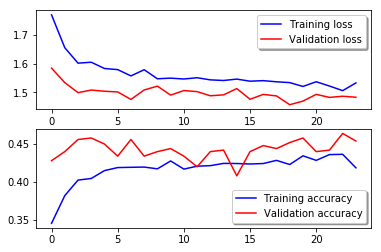

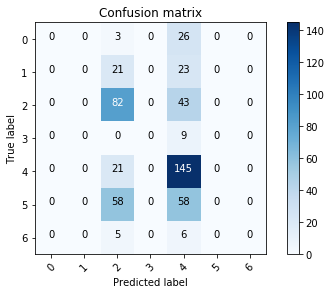

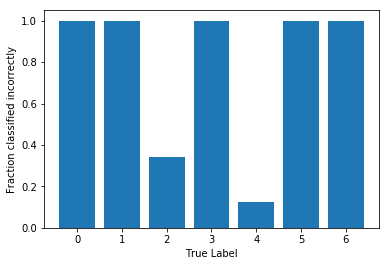

In [0]:

fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

#"Confusion Matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred_Model1 = model1.predict(x_test_std)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_Model1,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plt.figure(4)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


#"How much each class is correct"

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

plt.figure(5)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')

In [0]:



def resize_data(data):
    data_upscaled = np.zeros((data.shape[0], 299, 299, 3))
    for i, img in enumerate(data):
        large_img = cv2.resize(img, dsize=(299, 299), interpolation=cv2.INTER_CUBIC)
        data_upscaled[i] = large_img

    return data_upscaled

x_train_resized = resize_data(x_train)
x_test_resized = resize_data(x_test)


In [0]:
del imageid_path_dict, lesion_type_dict
del test, train
del tile_df
del tic, toc

In [0]:

from keras.applications.inception_v3 import InceptionV3
from keras.preprocessing import image
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D
from keras import backend as K

# create the base pre-trained model
base_model = InceptionV3(weights='imagenet', include_top=False)

# add a global spatial average pooling layer
x = base_model.output
x = GlobalAveragePooling2D()(x)
# let's add a fully-connected layer
x = Dense(1024, activation='relu')(x)
# and a logistic layer -- let's say we have 200 classes
predictions = Dense(7, activation='softmax')(x)

# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
#for layer in base_model.layers:
#    layer.trainable = False
# Freeze All Layers Except Bottleneck Layers for Fine-Tuning
for layer in model.layers:
    if layer.name in ['predictions']:
        continue
    layer.trainable = False















87916544/87910968 [==============================] - 2s 0us/step




In [0]:

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy',
             metrics=['accuracy'])

# train the model on the new data for a few epochs
#model.fit_generator(...)


In [0]:
model.summary()

In [0]:


"""
Modificado renan
"""
gen_data_epochs = 24

history21 = model.fit(x_train,y_train,batch_size=24,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test, y_test))
#
#
#history = model.fit(x_train, y_train,
#                    batch_size=batch_size,
#                    epochs=epochs,
#                    verbose=1)
## For some reason we get an error unless we start with model.fit before model.fit_generator
#history21 = model.fit_generator( 
#        generator=datagen.flow(x_train_resized, y_train, batch_size=batch_size),
#        steps_per_epoch=len(x_train) // gen_data_epochs,
#        epochs=gen_data_epochs,
#        verbose=1,
#        validation_data=(x_test_resized, y_test))
"""
Modificado renan
"""



Train on 4515 samples, validate on 500 samples
Epoch 1/24
4515/4515 [==============================] - 271s 60ms/step - loss: 1.9863 - acc: 0.1907 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 2/24
4515/4515 [==============================] - 265s 59ms/step - loss: 1.9830 - acc: 0.1845 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 3/24
4515/4515 [==============================] - 259s 57ms/step - loss: 1.9856 - acc: 0.1865 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 4/24
4515/4515 [==============================] - 254s 56ms/step - loss: 1.9876 - acc: 0.1849 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 5/24
4515/4515 [==============================] - 255s 57ms/step - loss: 1.9882 - acc: 0.1765 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 6/24
4515/4515 [==============================] - 256s 57ms/step - loss: 1.9911 - acc: 0.1818 - val_loss: 12.3741 - val_acc: 0.1760
Epoch 7/24
4515/4515 [==============================] - 254s 56ms/step - loss: 1.9929 - acc: 0.1772 - val_loss: 12.3741 - val

'\nModificado renan\n'

In [0]:

# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers[:249]:
   layer.trainable = False
for layer in model.layers[249:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy')

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
#model.fit_generator(...)



In [0]:


"""
Modificado renan
"""
gen_data_epochs = 24

# For some reason we get an error unless we start with model.fit before model.fit_generator
history22 = model.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test_std, y_test))
"""
Modificado renan
"""

NameError: ignored

NameError: ignored

<Figure size 432x288 with 0 Axes>

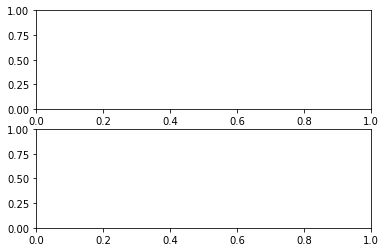

In [0]:


plt.figure(11)
ax = plt.subplots(2,1)
plt.plot(history22.history['loss'], color='b', label="Training loss")
plt.plot(history22.history['val_loss'], color='r', label="Validation loss")
legend = plt.legend(loc='best', shadow=True)

ax[1].plot(history22.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history22.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)


"""
Modificado renan
"""
for layer in model.layers:
    layer.trainable = True

model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

history23 = model.fit_generator( 
        generator=datagen.flow(x_train, y_train, batch_size=batch_size),
        steps_per_epoch=len(x_train) // gen_data_epochs,
        epochs=gen_data_epochs,
        verbose=1,
        validation_data=(x_test_std, y_test))    
    
plt.figure(12)
ax = plt.subplots(2,1)
ax[0].plot(history23.history['loss'], color='b', label="Training loss")
ax[0].plot(history23.history['val_loss'], color='r', label="Validation loss",axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history23.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history23.history['val_acc'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)    

"""
Modificado renan
"""

#################################################################
#################################################################
#################################################################
#################################################################
#################################################################


In [0]:


def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
y_pred_Model2 = model.predict(x_test_std)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred_Model2,axis = 1) 
# Convert validation observations to one hot vectors
y_true = np.argmax(y_test,axis = 1) 
# compute the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes) 
# plot the confusion matrix
plt.figure(13)
plot_confusion_matrix(confusion_mtx, classes = range(7)) 


#"How much each class is correct"

label_frac_error = 1 - np.diag(confusion_mtx) / np.sum(confusion_mtx, axis=1)

plt.figure(14)
plt.bar(np.arange(7),label_frac_error)
plt.xlabel('True Label')
plt.ylabel('Fraction classified incorrectly')